# Создание и обучение YOLOv3

# Подключение библиотек и Google диска

In [ ]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pillow==7.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google

import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем
from zipfile import ZipFile

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_img = 'drive/MyDrive/Colab_Notebooks/YOLO/img_celeba.7z'

# Скачиваю обучающий набор

In [ ]:
import py7zr
with py7zr.SevenZipFile(path_img, mode='r') as z:
    z.extractall()

In [ ]:
with open('drive/MyDrive/Colab_Notebooks/YOLO/list_bbox_celeba.txt') as f:
  for _ in range(3):
    line = f.readline()
  data = {}
  while line:
    line = line.split()
    data[line[0]] = list(map(lambda x: int(x), line[1::]))

    line = f.readline()

In [ ]:
images = []
y_train = []
from skimage.io import imread
import os
roots = 'img_celeba'

for roots, dirs, file in os.walk(os.path.join(roots)):
  for el in file:
    y_train.append(data[el])

/usr/local/lib/python3.10/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
from skimage.transform import resize
size = (416, 416)
def resizing(images, y, size):
  X = []
  y_train_rec = []
  for i, x in enumerate(images):
      y_coeff = 416 / x.shape[0] + 1e-10
      x_coeff = 416 / x.shape[1] + 1e-10
      x = rgb_to_hsv(np.array(x) / 255.)
      X.append(resize(x, size, mode='constant', anti_aliasing=True,))
      y_train_rec.append([y[i][0]*x_coeff, y[i][1]*y_coeff, y[i][2]*x_coeff, y[i][3]*y_coeff, 1, 1])

  return X, y_train_rec

In [ ]:
def plot_image(x, y):
  plt.imshow(x)
  x_min = y[0]
  x_max = y[0] + y[2]
  y_min = y[1]
  y_max = y[1] + y[3]
  plt.plot([x_min, x_max, x_max, x_min,  x_min],[y_min, y_min, y_max, y_max, y_min])

  plt.show()

Пример изображения из dataseta

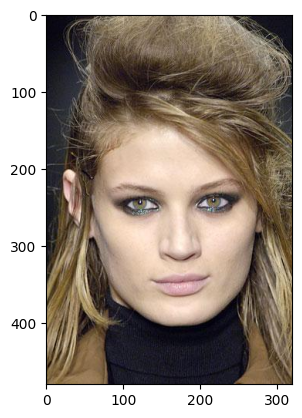

In [ ]:
plt.imshow(imread(os.path.join(roots, file[0])))
plt.show()

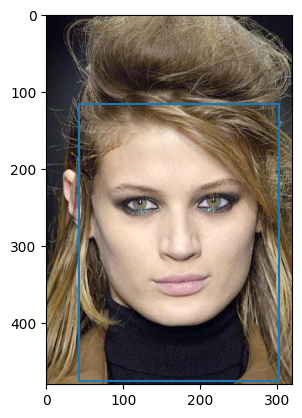

In [ ]:
plot_image(imread(os.path.join(roots, file[0])), data[file[0]])

# Создание анкоров

In [ ]:
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]])
num_anchors = len(anchors)

Функция генерации данных

In [ ]:
def data_generator(files, boxes, batch_size, anchors, input_shape):
    n = len(files) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    while True:
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        for b in range(batch_size): # Пробегаем по всему batch_size
            if i==0: # Если первая итерация цикла
                ind = list(range(n))
                np.random.shuffle(ind) # Перемешиваем элементы
            image_data.append(imread(os.path.join(root, file[ind[i]]))) # Добавляем полученную картинку в результирующий массив
            box_data.append(boxes[file[ind[i]]]) # Добавляем полученную ограничивающую рамку в массив bounfing_box
            image_res, box_res = resizing(image_data, box_data, input_shape)
            i = (i+1) % n # Обновляем значение индека (не превышая общего количества элементов)
        image_res = np.array(image_res) # Преобразуем в numpy
        box_res = np.array(box_res) # Преобразуем в numpy

        y_true = get_y(box_res, anchors, input_shape) # По значению ограничивающей рамки получаем y_true
        return (image_res, *y_true), np.zeros(batch_size) # Возвращаем порцию данных для обучения

Функция подсчета y

In [ ]:
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32') # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32') # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] # Получаем высоту и ширину bounding_box В относительных значениях

    m = true_boxes.shape[0] # Получаем количество элементов в batch_size
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])


    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]), 6),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue # Выходим если она нулевая
        wh = np.expand_dims(wh, -2) # Добавляем размерность

        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5] = 1
    return y_true

# Функции создания модели

**Функция создания блока Conv2D, BatchNormalization, LeakyRelu**

 Входные параметры:
- inputs - Стартовый слой, к которому добавляется Res-блок
- args - массив неименованных параметров
- kwargs  - массив именованных параметров

In [ ]:
def ConvBL(
        inputs,
        *args,
        **kwargs
        ):
    new_kwargs = {'use_bias': False} 
    new_kwargs['kernel_regularizer'] = l2(5e-4)
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' 
    new_kwargs.update(kwargs)
    x = Conv2D(*args, **new_kwargs) (inputs) 
    x = BatchNormalization() (x) 
    x = LeakyReLU(alpha=0.1) (x) 
    return x

**Функция создания Residual блока**

 Входные параметры:
- inputs - Стартовый слой, к которому добавляется Res-блок
- num_filters - количество нейронов
- num_blocks  - количество блоков

In [ ]:
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) 
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) 
    for i in range(num_blocks): 
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x 

**Функция создания модели YOLOv3**

 Входные параметры:
- inputs - Входной слой модели
- num_sub_anchors - количество анкоров в каждом уровне сеток

In [ ]:
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
   
    # Базовая часть модели YOLOv3

    x = ConvBL (inputs, 32, (3, 3)) 
    x = resblock (x, 64, 1) 
    x = resblock (x, 128, 2) 
    x = resblock (x, 256, 8) 
    x = resblock (x, 512, 8) 
    x = resblock (x, 1024, 4) 
    base_model = Model(inputs, x) 

 
    # Detection часть модели YOLOv3

    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))

    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (6), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)


    # 26x26 (обнаружение средних объектов)
    x = ConvBL(x, 256, ( 1, 1))
    x = UpSampling2D(2) (x) 
    x = Concatenate()([x,base_model.layers[152].output])

    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))

    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (6), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)

    # 52 x 52 (обнаружение маленьких объектов)
    x = ConvBL(x, 128, ( 1, 1))
    x = UpSampling2D(2) (x)  
    x = Concatenate()([x,base_model.layers[92].output])

    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))

    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (6), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)

    return Model(inputs, [y1, y2, y3])

  **Функция подсчета IoU**

In [ ]:
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) 
    xy1 = input1[..., :2] 
    wh1 = input1[..., 2:4]
    wh_half1 = wh1 / 2. 
    top_left1 = xy1 - wh_half1 
    right_bottom1 = xy1 + wh_half1 

    input2 = K.expand_dims(input2, 0) 
    wh2 = input2[..., 2:4] 
    wh_half2 = wh2 / 2. 
    top_left2 = xy2 - wh_half2 
    right_bottom2 = xy2 + wh_half2 

    intersect_mins = K.maximum(top_left1, top_left2) 
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) 
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) 
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] 

    area1 = wh1[..., 0] * wh1[..., 1] 
    area2 = wh2[..., 0] * wh2[..., 1] 

    return (intersect_area + 1e-10) / (area1 + area2 - intersect_area + 1e-10) 

**Функция подсчета ошибки**

 Входные параметры:
- inputs - Входные данные
- num_anchors - общее количество анкоров

In [ ]:
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 
    num_layers = num_anchors // 3 
    y_pred = inputs[:num_layers] 
    y_true = inputs[num_layers:] 
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] 
   

    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0]))

    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]

    loss = 0

    m = K.shape(y_pred[0])[0] 
    batch_size = K.cast(m, K.dtype(y_pred[0]))

    for l in range(num_layers): 
        object_mask = y_true[l][..., 4:5] 

        true_class = y_true[l][..., 5:] 

        num_sub_anchors = len(anchors[anchor_mask[l]]) 
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])

        grid_shape = K.shape(y_pred[l])[1:3] 
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) 
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) 
        grid = K.concatenate([grid_x, grid_y]) 
        grid = K.cast(grid, K.dtype(y_pred[l])) 

        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, 6])

        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] 
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1] + 1e-10)
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh))
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])

        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Считаем ошибку в определении обнаружения какого-либо класса
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool') 

        # Функция, определяющая данные, которые требуется игнорировать
        def loop_body(
                b,
                ignore_mask
                ):
           
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
            iou = calc_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask 

        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
        ignore_mask = ignore_mask.stack() 
        ignore_mask = K.expand_dims(ignore_mask, -1) 

        # Считаем значение ошибки
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )

        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)

        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss + 1e-10

    return loss 

**Функция создания полной модели**

 Входные параметры:
- input_shape - размерность входного изображения для модели YOLO
- num_anchors - общее количество анкоров
- use_weights - использовать ли предобученные веса
- weights_path - путь к сохраненным весам модели

In [ ]:
def create_model(
        input_shape,
        num_anchors,
        use_weights = False,
        weights_path = 'yolo.h5'
        ):
    w, h = input_shape
    inputs = Input(shape = (w, h, 3))

    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, 6))] 
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, 6))) 
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, 6))) 

    model_yolo = create_YOLOv3(inputs, num_anchors // 3) 
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(1)) 
  
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) 
        print ('Загружены веса из файла {}.'.format(weights_path)) 

    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])

    return Model([inputs, *y_true], outputs) 

# Создание модели

In [ ]:
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=path +'weights/YOLOv3__el1000__opt0.0001__ep0_100.h5')

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Базы/Самолеты/weights/YOLOv3__el1000__opt0.0001__ep0_100.h5.


In [ ]:
model_YOLO.input

[<tf.Tensor 'input_1:0' shape=(None, 416, 416, 3) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 13, 13, 3, 6) dtype=float32>,
 <tf.Tensor 'input_3:0' shape=(None, 26, 26, 3, 6) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(None, 52, 52, 3, 6) dtype=float32>]

In [ ]:
model_YOLO.output

<tf.Tensor 'yolo_loss/add_17:0' shape=() dtype=float32>

In [ ]:
model_YOLO.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Обучение модели

## Подготовка данных

In [ ]:
val_split = 0.1 

np.random.seed(17)
np.random.shuffle(file)
np.random.seed(None)

num_train = int(len(file) * val_split) 
num_val = int(num_train * val_split) 
print (num_val)
print (num_train)

2025
20259


## Обучение с различными шагами


### lr_value = 1e-3

#### Первые 100 эпох

In [ ]:
lr_value = 1e-3 
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time()
batch_size = 8 
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5' 
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss']) 
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv') 
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv') 

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек')

Epoch 1/100
112/112 [==============================] - 408s 4s/step - loss: 739.3715 - val_loss: 372.2573
Epoch 2/100
112/112 [==============================] - 122s 1s/step - loss: 64.2320 - val_loss: 364.6869
Epoch 3/100
112/112 [==============================] - 122s 1s/step - loss: 38.1886 - val_loss: 112.3690
Epoch 4/100
112/112 [==============================] - 122s 1s/step - loss: 28.9222 - val_loss: 317.1345
Epoch 5/100
112/112 [==============================] - 122s 1s/step - loss: 24.5518 - val_loss: 283.2276
Epoch 6/100
112/112 [==============================] - 121s 1s/step - loss: 21.9177 - val_loss: 112.3214
Epoch 7/100
112/112 [==============================] - 122s 1s/step - loss: 20.2556 - val_loss: 43.4915
Epoch 8/100
112/112 [==============================] - 121s 1s/step - loss: 18.9516 - val_loss: 165.6829
Epoch 9/100
112/112 [==============================] - 120s 1s/step - loss: 18.3798 - val_loss: 25.2147
Epoch 10/100
112/112 [==============================] - 

#### Еще 100 эпох на текущем шаге

In [ ]:
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5' 
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
lr_value = 1e-3 

model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Airplanes/weight/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5.


In [ ]:
startTime = time.time()
batch_size = 8 
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5' 

history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100
                    )

model_YOLO.save_weights(model_filename)

loss = np.array(history.history['loss']) 
val_loss = np.array(history.history['val_loss']) 
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv') 
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv') 

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') 



Epoch 101/200
112/112 [==============================] - 389s 3s/step - loss: 11.2054 - val_loss: 10.8183
Epoch 102/200
112/112 [==============================] - 135s 1s/step - loss: 7.2338 - val_loss: 10.4905
Epoch 103/200
112/112 [==============================] - 137s 1s/step - loss: 6.5583 - val_loss: 18.0798
Epoch 104/200
112/112 [==============================] - 135s 1s/step - loss: 9.6466 - val_loss: 10.2804
Epoch 105/200
112/112 [==============================] - 130s 1s/step - loss: 7.7076 - val_loss: 10.6830
Epoch 106/200
112/112 [==============================] - 131s 1s/step - loss: 6.8981 - val_loss: 7.6246
Epoch 107/200
112/112 [==============================] - 133s 1s/step - loss: 6.1926 - val_loss: 8.7984
Epoch 108/200
112/112 [==============================] - 134s 1s/step - loss: 6.3892 - val_loss: 6.8658
Epoch 109/200
112/112 [==============================] - 135s 1s/step - loss: 5.7967 - val_loss: 7.5510
Epoch 110/200
112/112 [==============================] -

### lr_value = 1e-4

#### Первые 100 эпох

In [ ]:
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5' 
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) 
lr_value = 1e-4 

model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Airplanes/weight/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5.


In [ ]:
startTime = time.time() 
batch_size = 8 
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5'

history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

model_YOLO.save_weights(model_filename)

loss = np.array(history.history['loss']) 
val_loss = np.array(history.history['val_loss']) 
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv') 
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv') 

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек')



Epoch 1/100
112/112 [==============================] - 357s 3s/step - loss: 3.8027 - val_loss: 3.6469
Epoch 2/100
112/112 [==============================] - 121s 1s/step - loss: 3.3857 - val_loss: 3.3912
Epoch 3/100
112/112 [==============================] - 123s 1s/step - loss: 3.1930 - val_loss: 3.1847
Epoch 4/100
112/112 [==============================] - 122s 1s/step - loss: 3.1657 - val_loss: 3.3807
Epoch 5/100
112/112 [==============================] - 125s 1s/step - loss: 3.1198 - val_loss: 3.0613
Epoch 6/100
112/112 [==============================] - 123s 1s/step - loss: 3.0338 - val_loss: 3.2223
Epoch 7/100
112/112 [==============================] - 123s 1s/step - loss: 3.0769 - val_loss: 3.5416
Epoch 8/100
112/112 [==============================] - 123s 1s/step - loss: 3.0755 - val_loss: 3.1134
Epoch 9/100
112/112 [==============================] - 123s 1s/step - loss: 3.0540 - val_loss: 3.2570
Epoch 10/100
112/112 [==============================] - 123s 1s/step - loss: 3.0

#### Еще 100 эпох

In [ ]:
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5' 
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) 
lr_value = 1e-4 

model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Airplanes/weight/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5.


In [ ]:
startTime = time.time() 
batch_size = 8 
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5' 

history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100
                    )

model_YOLO.save_weights(model_filename)

loss = np.array(history.history['loss']) 
val_loss = np.array(history.history['val_loss']) 
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv') 
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv') 

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') 



Epoch 101/200
112/112 [==============================] - 282s 3s/step - loss: 2.6598 - val_loss: 2.8199
Epoch 102/200
112/112 [==============================] - 122s 1s/step - loss: 2.6918 - val_loss: 2.7693
Epoch 103/200
112/112 [==============================] - 123s 1s/step - loss: 2.7057 - val_loss: 2.7863
Epoch 104/200
112/112 [==============================] - 123s 1s/step - loss: 2.7065 - val_loss: 3.4924
Epoch 105/200
112/112 [==============================] - 122s 1s/step - loss: 2.7098 - val_loss: 2.7717
Epoch 106/200
112/112 [==============================] - 123s 1s/step - loss: 2.6619 - val_loss: 2.8445
Epoch 107/200
112/112 [==============================] - 123s 1s/step - loss: 2.6541 - val_loss: 2.8447
Epoch 108/200
112/112 [==============================] - 123s 1s/step - loss: 2.7253 - val_loss: 3.0369
Epoch 109/200
112/112 [==============================] - 123s 1s/step - loss: 2.6556 - val_loss: 2.8315
Epoch 110/200
112/112 [==============================] - 122s 

### lr_value = 1e-5

#### Первые 100 эпох

In [ ]:
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5' 
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) 
print ('{} загружены.'.format(model_weight))
lr_value = 1e-5 

model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Airplanes/weight/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5.
/content/drive/My Drive/Airplanes/weight/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5 загружены.


In [ ]:
startTime = time.time() 
batch_size = 8 
model_filename = path +'weight/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5' 

history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

model_YOLO.save_weights(model_filename)

loss = np.array(history.history['loss']) 
val_loss = np.array(history.history['val_loss']) 
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv') 
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv') 

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') 



Epoch 1/100
112/112 [==============================] - 392s 4s/step - loss: 2.5423 - val_loss: 2.5513
Epoch 2/100
112/112 [==============================] - 124s 1s/step - loss: 2.4903 - val_loss: 3.0593
Epoch 3/100
112/112 [==============================] - 123s 1s/step - loss: 2.4443 - val_loss: 2.6561
Epoch 4/100
112/112 [==============================] - 125s 1s/step - loss: 2.4297 - val_loss: 2.6792
Epoch 5/100
112/112 [==============================] - 125s 1s/step - loss: 2.5153 - val_loss: 2.4583
Epoch 6/100
112/112 [==============================] - 123s 1s/step - loss: 2.4099 - val_loss: 2.4941
Epoch 7/100
112/112 [==============================] - 123s 1s/step - loss: 2.4036 - val_loss: 2.5114
Epoch 8/100
112/112 [==============================] - 123s 1s/step - loss: 2.4557 - val_loss: 2.3701
Epoch 9/100
112/112 [==============================] - 124s 1s/step - loss: 2.4832 - val_loss: 2.6480
Epoch 10/100
112/112 [==============================] - 124s 1s/step - loss: 2.4

### Графики

#### Первые 100 эпох

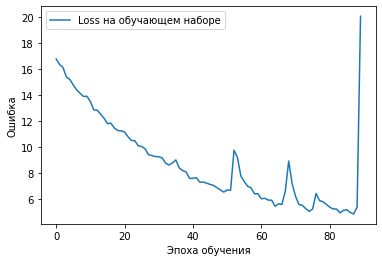

min: 4.887869922178132
last: 20.03816760437829


In [ ]:
loss1 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv')
values = loss1.values[:, 1]
plt.plot(values[10:100],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', values.min())
print ('last:', values[-1])

#### 200 эпох

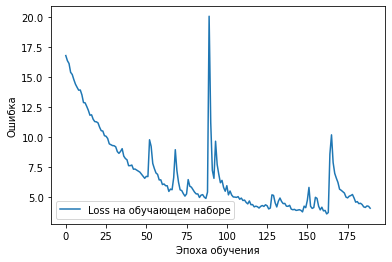

min: 3.6010584277766093
last: 4.074403245534215


In [ ]:
loss2 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv')
values2 = loss2.values[:, 1]
full_loss = np.concatenate((values, values2))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### 300 эпох

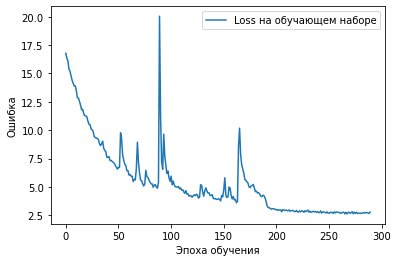

min: 2.618721180728504
last: 2.7780272683926994


In [ ]:
loss3 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv')
values3 = loss3.values[:, 1]
full_loss = np.concatenate((full_loss, values3))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

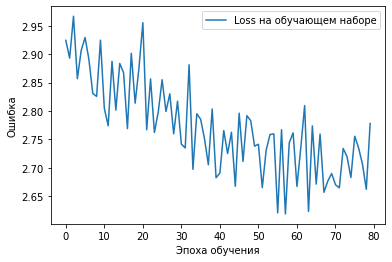

min: 2.618721180728504


In [ ]:
plt.plot(full_loss[-80:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())

#### 400 эпох

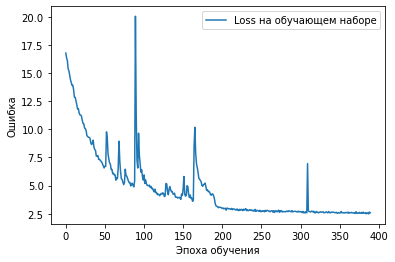

min: 2.480011485517025
last: 2.5748181151492253


In [ ]:
loss4 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv')
values4 = loss4.values[:, 1]
full_loss = np.concatenate((full_loss, values4))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])










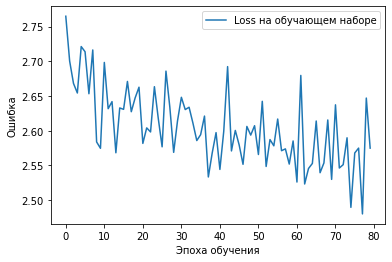

min: 2.480011485517025
last: 2.5748181151492253


In [ ]:
plt.plot(full_loss[-80:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### 500 эпох

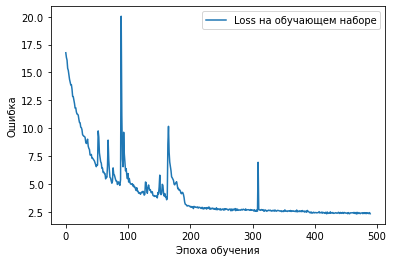

min: 2.3316804777298654
last: 2.345724961587361


In [ ]:
loss5 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv')
values5 = loss5.values[:, 1]
full_loss = np.concatenate((full_loss, values5))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

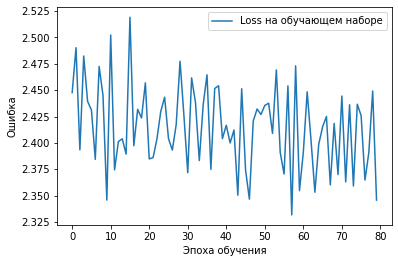

min: 2.3316804777298654
last: 2.345724961587361


In [ ]:
plt.plot(full_loss[-80:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### На тестовой выборке

In [ ]:
val_loss1 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv').values[:,1]
val_loss2 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv').values[:,1]
val_loss3 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv').values[:,1]
val_loss4= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv').values[:,1]
val_loss5= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv').values[:,1]
print ('Ошибки на последней эпохе каждого шага:')
print ('100 эпох:', str(round(val_loss1[-1], 4)))
print ('210 эпох:', str(round(val_loss2[-1], 4)))
print ('300 эпох:', str(round(val_loss3[-1], 4)))
print ('400 эпох:', str(round(val_loss4[-1], 4)))
print ('500 эпох:', str(round(val_loss5[-1], 4)))

Ошибки на последней эпохе каждого шага:
100 эпох: 324649682.6667
210 эпох: 5.4149
300 эпох: 2.8133
400 эпох: 2.53
500 эпох: 2.591


# Обнаружение объектов


In [ ]:
path_img = imread('drive/MyDrive/Colab_Notebooks/YOLO/000010.jpg')

In [ ]:
results = model_YOLO(path_img)
score = results[1][0][0][0]
x_min_1 = results[0][0][0][0]
x_max_1 = results[0][0][0][2]
y_min_1 = results[0][0][0][1]
y_max_1 = results[0][0][0][3]

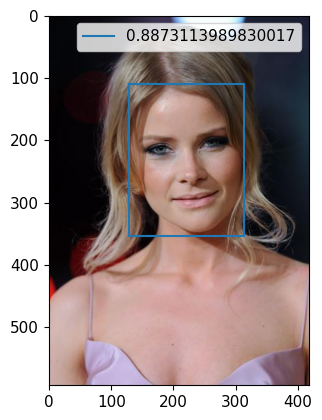

In [ ]:
plt.imshow(path_img)
plt.plot([x_min_1, x_min_1, x_max_1, x_max_1, x_min_1],[y_min_1, y_max_1, y_max_1, y_min_1, y_min_1])
plt.legend(results[1][0][0])
plt.show()

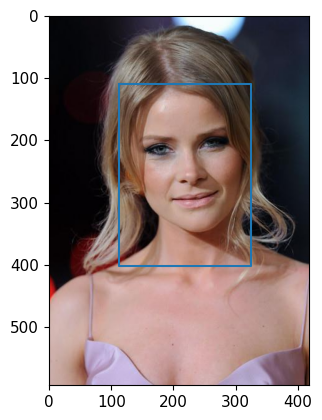

In [ ]:
plt.imshow(path_img)
plt.plot([y_true[0], y_true[0], y_true[2]+y_true[0], y_true[2]+y_true[0], y_true[0]],[y_true[1], y_true[3]+y_true[1], y_true[3]+y_true[1], y_true[1], y_true[1]])
plt.show()

In [ ]:
y_true = [113, 110, 211, 292]
y_pred = [129, 110, 314, 353]  
true_area = y_true[2]*y_true[3]
pred_area = (y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1])
correct_area = (min(y_pred[2], y_true[2]+y_true[0]) - max(y_pred[0], y_true[0])) * (min(y_pred[3], y_true[3]+y_true[1]) - max(y_pred[1], y_true[1]))
iou = correct_area / (true_area + pred_area - correct_area)
iou

0.7296468220476531

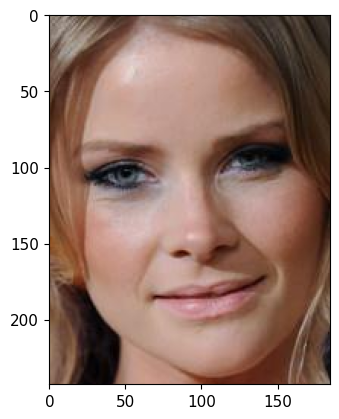

In [ ]:
im = Image.open('drive/MyDrive/Colab_Notebooks/YOLO/000010.jpg')
im_crop = im.crop((x_min_1, y_min_1, x_max_1, y_max_1))
plt.imshow(im_crop)